In [10]:
from calibration_metrics import partition_bins
import matplotlib.pyplot as plt
import torch
%matplotlib inline
plt.style.use('ggplot')

In [36]:
def plot_reliability_diagrams(fname, predictions, confidences, references):
    bins, bin_sizes, bin_accs, bin_avg_confs = partition_bins(predictions, confidences, references)
    bins = bins.detach().numpy()
    bin_accs = bin_accs.detach().numpy()
    bin_avg_confs = bin_avg_confs.detach().numpy()

    plt.bar(bins, bin_avg_confs, width=0.1, alpha=0.3, edgecolor='black', hatch='/')
    plt.bar(bins, bin_accs, width=0.1, alpha=0.7, edgecolor='black')
    plt.plot([0, 1.05],[0, 1.05], '--', color='gray', linewidth=2)
    plt.ylim([0, 1.05])
    plt.xlim([0, 1.05])
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(f"figures/{fname}")
    
def load_outputs(path):
    predictions = torch.load(f"{path}/predictions.pt")
    confidences = torch.load(f"{path}/confidences.pt")
    references = torch.load(f"{path}/references.pt")
    
    return predictions, confidences, references

def confidences_histogram(confidences):
    plt.hist(confidences.tolist(), bins=100, range=(0,1))
    plt.show()

# Reliability Diagram
## CIFAR-10
### Uncalibrated

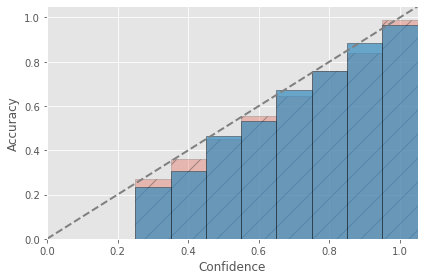

In [37]:
predictions, confidences, references = load_outputs("outputs/resnet_cifar-10_0.8017_0.0229_0.0561")
plot_reliability_diagrams("CIFAR-uncalibrated", predictions, confidences, references)

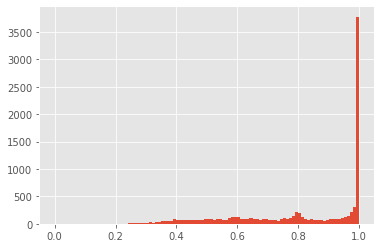

In [38]:
confidences_histogram(confidences)

### Platt

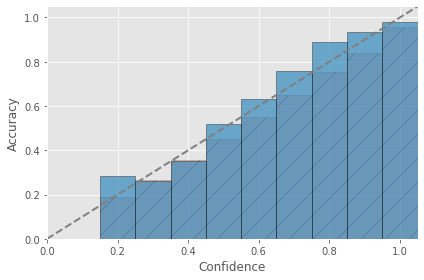

In [39]:
predictions, confidences, references = load_outputs("outputs/resnet-platt_cifar-10_0.7963_0.0665_0.1354")
plot_reliability_diagrams("CIFAR-Platt", predictions, confidences, references)

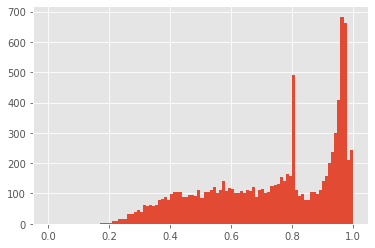

In [40]:
confidences_histogram(confidences)

### Temperature

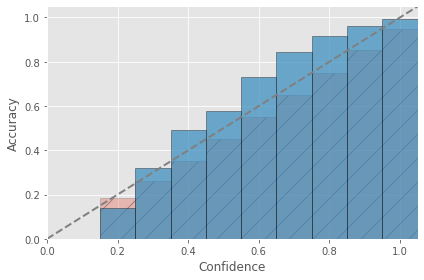

In [41]:
predictions, confidences, references = load_outputs("outputs/resnet-temp_cifar-10_0.8052_0.1147_0.1927")
plot_reliability_diagrams("CIFAR-Temp", predictions, confidences, references)

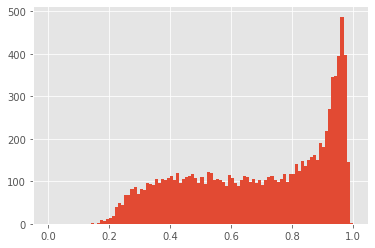

In [42]:
confidences_histogram(confidences)

## SVHN
### Uncalibrated

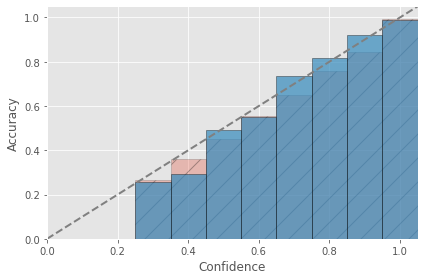

In [43]:
predictions, confidences, references = load_outputs("outputs/resnet_SVHN_0.9471_0.0126_0.0862")
plot_reliability_diagrams("SVHN-uncalibrated", predictions, confidences, references)

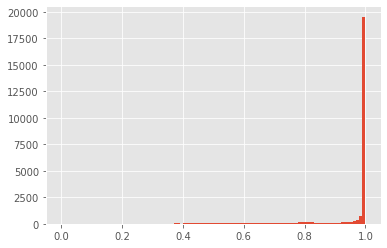

In [44]:
confidences_histogram(confidences)

### Platt

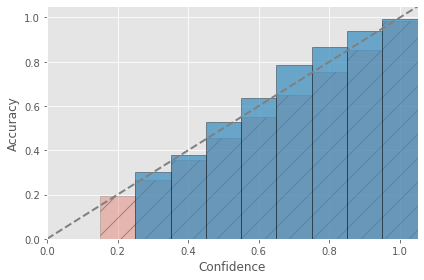

In [45]:
predictions, confidences, references = load_outputs("outputs/resnet-platt_SVHN_0.9482_0.0258_0.1920")
plot_reliability_diagrams("CIFAR-Platt", predictions, confidences, references)

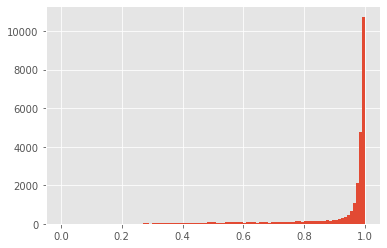

In [46]:
confidences_histogram(confidences)

### Temperature

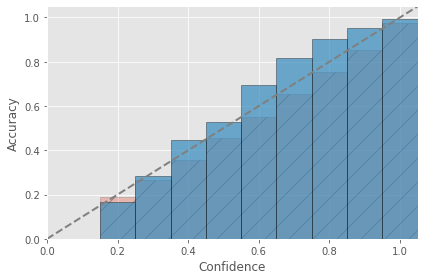

In [47]:
predictions, confidences, references = load_outputs("outputs/resnet-temp_SVHN_0.9481_0.0425_0.1644")
plot_reliability_diagrams("CIFAR-Platt", predictions, confidences, references)

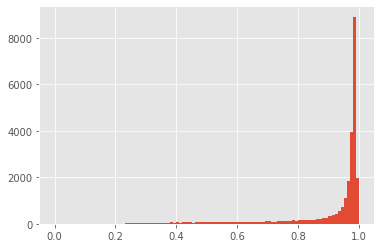

In [48]:
confidences_histogram(confidences)

# Regression
TODO: performance of a single model

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from regressor import MLP, QuantileMLP
import glob
%matplotlib inline
plt.style.use('ggplot')

model_dir = "/mnt/e/models/iso_models"
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def predict(model, inputs, device):
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
    
    return outputs

def ensemble_predict(model_paths, model, inputs, device):
    mus, sigmas = [], []
    print(f"Loading model from {model_paths}")
    for path in glob.iglob(model_paths):
        model.load_state_dict(torch.load(path, map_location=device))
        
        mu, log_sigma2 = predict(model, inputs, device)
        sigma = torch.sqrt(torch.exp(log_sigma2))
        mus.append(mu.unsqueeze(0))
        sigmas.append(sigma.unsqueeze(0))
        
    mus = torch.cat(mus, dim=0) # no_model, no_inputs, no_outputs
    sigmas = torch.cat(sigmas, dim=0)
    
    mus = mus.mean(dim=0)
    sigmas = sigmas.mean(dim=0)
    
    mus = mus.detach().cpu().numpy()
    sigmas = sigmas.detach().cpu().numpy()
    if mus.shape[-1] == 1:
        mus = mus.reshape(-1)
    if sigmas.shape[-1] == 1:
        sigmas = sigmas.reshape(-1)
    return mus, sigmas * 2

def correct_coverage(references, lower, upper):
    less_than_upper = references <= upper
    ref_upper = references[less_than_upper]
    sub_lower = lower[less_than_upper]
    in_range = ref_upper[ref_upper >= sub_lower]
    return len(in_range)/len(references)

def plot_solar_regression(train_data, test_data, X, y, lower, upper):
    plt.scatter(train_data[:,0], train_data[:,1], c='b', label='train')
    plt.scatter(test_data[:,0], test_data[:,1], c='r', label='test')
    plt.plot(X, y, c='g', label='mean')
    plt.fill_between(X, lower, upper, color="orange", label='interval', alpha=0.5)
    plt.xlim(-230, 230)
    plt.ylim(-3, 3)
    plt.legend()
    plt.show()
    
def project_score_function(references, lower, upper):
    # project distance from y onto uncertainties
    values = np.vstack((lower - references, references - upper))
    return np.max(values, axis=0)

def conformal_calibration(references, lower, upper, quantile=0.95):
    scores = project_score_function(references, lower, upper)
    return np.quantile(scores, quantile)



## Solar

In [7]:
train_data = np.load("/mnt/e/data/solar/solar_data_train.npy")
val_data = np.load("/mnt/e/data/solar/solar_data_val.npy")
test_data = np.load("/mnt/e/data/solar/solar_data_test.npy")

train_data.shape, val_data.shape, test_data.shape

((261, 2), (30, 2), (100, 2))

In [8]:
input_dim = 1
output_dim = 1
num_units = 40
drop_prob = 0.01

mlp = MLP(input_dim=input_dim, output_dim=output_dim, num_units=num_units, drop_prob=drop_prob)
print(mlp)

solar_model_paths = os.path.join(model_dir, "mlp", f"mlp_solar_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_y, line_error = ensemble_predict(solar_model_paths, mlp, line_X, device)

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_y.shape, line_error.shape

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
  )
  (mu): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
  (log_sigma2): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt


((4600,), (4600,), (4600,))

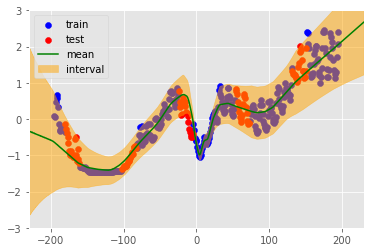

In [9]:
line_upper = line_y + line_error
line_lower = line_y - line_error
plot_train = np.concatenate((train_data, val_data))

plot_solar_regression(plot_train, test_data, line_X, line_y, line_lower, line_upper)

### Correct coverage

In [11]:
test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_preds, test_errors = ensemble_predict(solar_model_paths, mlp, test_X, device)
test_lower = test_preds - test_errors
test_upper = test_preds + test_errors
coverage = correct_coverage(test_data[:,1], test_lower, test_upper)
coverage # expected coverage: 0.95

Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt


0.91

### Conformal calibration

In [12]:
val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_preds, val_errors = ensemble_predict(solar_model_paths, mlp, val_X, device)

val_lower = val_preds - val_errors
val_upper = val_preds + val_errors
q_score = conformal_calibration(val_data[:,1], val_lower, val_upper, 0.95)
q_score

Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt


-0.12468588948249847

In [14]:
correct_coverage(test_data[:,1], test_lower-q_score, test_upper+q_score) # expected coverage: 0.95

0.85

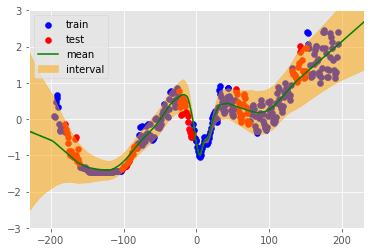

In [15]:
plot_solar_regression(plot_train, test_data, line_X, line_y, line_lower-q_score, line_upper+q_score)

## UCI

In [11]:
def UCI_calibration_error(dataset, val_data, test_data, device):
    val_X = val_data[:, :-1]
    val_y = val_data[:, -1]
    test_X = test_data[:, :-1]
    test_y = test_data[:, -1]
    print(test_X.shape)

    mlp_paths = os.path.join(model_dir, "mlp", f"mlp_{dataset}_*.pt")
    mlp = MLP(input_dim=test_X.shape[1], output_dim=1, num_units=20, drop_prob=0.01)
    # print(mlp)
    
    mlp_sigma_paths = os.path.join(model_dir, "mlp-sigma", f"mlp-sigma_{dataset}_*.pt")
    mlp_sigma = MLPSigma(input_dim=test_X.shape[1], output_dim=1, num_units=20, drop_prob=0.01)
    # print(mlp_sigma)

    print("### Before calibration ###")
    test_preds = ensemble_predict(mlp_paths, mlp, torch.from_numpy(test_X).float(), device)
    test_errors = get_2_sigma_error_bound(mlp_sigma_paths, mlp_sigma, torch.from_numpy(test_X).float(), device)
    lower = test_preds - test_errors
    upper = test_preds + test_errors
    coverage = correct_coverage(test_y, lower, upper)
    print(f"Coverage: {coverage}")
    print()
    
    print("### Conformal calibrating ###")
    val_preds = ensemble_predict(mlp_paths, mlp, torch.from_numpy(val_X).float(), device)
    val_errors = get_2_sigma_error_bound(mlp_sigma_paths, mlp_sigma, torch.from_numpy(val_X).float(), device)
    q_score = conformal_calibration(val_y, val_preds-val_errors, val_preds+val_errors, 0.95)
    print(f"Q-score: {q_score}")
    coverage = correct_coverage(test_y, lower-q_score, upper+q_score)
    print(f"Coverage: {coverage}")

    

### Housing

In [12]:
val_data = np.load("/mnt/e/data/house/val.npy")
test_data = np.load("/mnt/e/data/house/test.npy")
UCI_calibration_error("house", val_data, test_data, device)

(51, 12)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_house_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_house_*.pt
Coverage: 0.8431372549019608

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_house_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_house_*.pt
Q-score: -0.055141955617627886
Coverage: 0.8235294117647058


### Concrete

In [13]:
val_data = np.load("/mnt/e/data/concrete/val.npy")
test_data = np.load("/mnt/e/data/concrete/test.npy")
UCI_calibration_error("concrete", val_data, test_data, device)

(103, 7)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_concrete_*.pt
Coverage: 0.941747572815534

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_concrete_*.pt
Q-score: -0.19735190965947524
Coverage: 0.883495145631068


### Energy

In [43]:
val_data = np.load("/mnt/e/data/energy/val.npy")
test_data = np.load("/mnt/e/data/energy/test.npy")
UCI_calibration_error("energy", val_data, test_data, device)

(77, 8)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_energy_*.pt
Coverage: 0.922077922077922

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_energy_*.pt
Q-score: 0.0288851638844024
Coverage: 0.922077922077922


### Power

In [15]:
val_data = np.load("/mnt/e/data/power/val.npy")
test_data = np.load("/mnt/e/data/power/test.npy")
UCI_calibration_error("power", val_data, test_data, device)

(957, 3)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_power_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_power_*.pt
Coverage: 0.9644723092998955

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_power_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_power_*.pt
Q-score: -0.026340474956414235
Coverage: 0.9529780564263323


### Red wine

In [16]:
val_data = np.load("/mnt/e/data/red_wine/val.npy")
test_data = np.load("/mnt/e/data/red_wine/test.npy")
UCI_calibration_error("red_wine", val_data, test_data, device)

(160, 10)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_red_wine_*.pt
Coverage: 0.9125

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_red_wine_*.pt
Q-score: 0.021086417419998883
Coverage: 0.91875


### Yacht

In [17]:
val_data = np.load("/mnt/e/data/yacht/val.npy")
test_data = np.load("/mnt/e/data/yacht/test.npy")
UCI_calibration_error("yacht", val_data, test_data, device)

(31, 5)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_yacht_*.pt
Coverage: 0.9032258064516129

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_*.pt
Loading model from /mnt/e/models/iso_models/mlp-sigma/mlp-sigma_yacht_*.pt
Q-score: -0.7858473356015367
Coverage: 0.8387096774193549


# Quantile Regression

## Solar

In [18]:
train_data = np.load("/mnt/e/data/solar/solar_data_train.npy")
val_data = np.load("/mnt/e/data/solar/solar_data_val.npy")
test_data = np.load("/mnt/e/data/solar/solar_data_test.npy")

In [19]:
quantiles = [0.05, 0.5, 0.95]
model = QuantileMLP(input_dim=1, output_dim=1, num_units=20, drop_prob=0.01, quantiles=quantiles)
print(model)

solar_model_paths = os.path.join(model_dir, "quantile", f"quantile_solar_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_y = ensemble_predict(solar_model_paths, model, line_X, device)

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_y.shape

QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=60, out_features=3, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt


((4600,), (4600, 3))

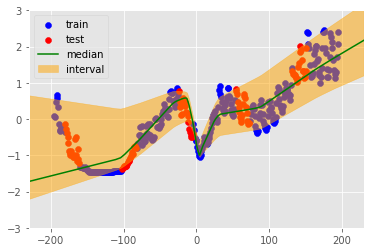

In [20]:
plot_train = np.concatenate((train_data, val_data))
plot_solar_regression(plot_train, test_data, line_X, line_y[:, 1], line_y[:, 0], line_y[:, 2])

In [21]:
test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_preds = ensemble_predict(solar_model_paths, model, test_X, device)
coverage = correct_coverage(test_data[:,1], test_preds[:, 0], test_preds[:, 2])
coverage # expected coverage: 0.9

Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt


0.84

In [22]:
val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_preds = ensemble_predict(solar_model_paths, model, val_X, device)

q_score = conformal_calibration(val_data[:,1], val_preds[:, 0], val_preds[:, 2], 0.9)
q_score

Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt


0.023632094264030522

In [23]:
coverage = correct_coverage(test_data[:,1], test_preds[:, 0]-q_score, test_preds[:, 2]+q_score)
coverage # expected coverage: 0.9

0.88

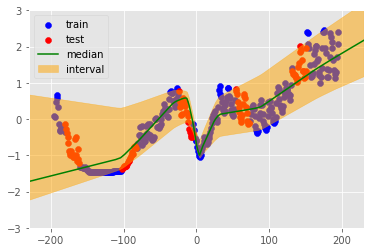

In [24]:
plot_solar_regression(plot_train, test_data, line_X, line_y[:, 1], line_y[:, 0]-q_score, line_y[:, 2]+q_score)

## UCI

In [25]:
def UCI_calibration_quantile(dataset, val_data, test_data, device):
    val_X = val_data[:, :-1]
    val_y = val_data[:, -1]
    test_X = test_data[:, :-1]
    test_y = test_data[:, -1]
    print(test_X.shape)
    
    quantiles = [0.05, 0.5, 0.95]

    model_paths = os.path.join(model_dir, "quantile", f"quantile_{dataset}_*.pt")
    model = QuantileMLP(input_dim=test_X.shape[1], output_dim=1, num_units=20, drop_prob=0.01, quantiles=quantiles)
    print(model)

    print("### Before calibration ###")
    test_preds = ensemble_predict(model_paths, model, torch.from_numpy(test_X).float(), device)
    lower = test_preds[:, 0]
    upper = test_preds[:, 2]
    coverage = correct_coverage(test_y, lower, upper)
    print(f"Coverage: {coverage}")
    print()

    print("### Conformal calibrating ###")
    val_preds = ensemble_predict(model_paths, model, torch.from_numpy(val_X).float(), device)
    q_score = conformal_calibration(val_y, val_preds[:, 0], val_preds[:, 2], 0.9)
    print(f"Q-score: {q_score}")
    coverage = correct_coverage(test_y, lower-q_score, upper+q_score)
    print(f"Coverage: {coverage}")

TODO: Biased validation set - use larger validation set

### Housing

In [26]:
val_data = np.load("/mnt/e/data/house/val.npy")
test_data = np.load("/mnt/e/data/house/test.npy")
UCI_calibration_quantile("house", val_data, test_data, device)

(51, 12)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=60, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_house_*.pt
Coverage: 0.6274509803921569

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_house_*.pt
Q-score: 0.023138037936446615
Coverage: 0.6666666666666666


### Concrete

In [27]:
val_data = np.load("/mnt/e/data/concrete/val.npy")
test_data = np.load("/mnt/e/data/concrete/test.npy")
UCI_calibration_quantile("concrete", val_data, test_data, device)

(103, 7)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=60, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_*.pt
Coverage: 0.8349514563106796

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_*.pt
Q-score: -0.006070125305096837
Coverage: 0.8252427184466019


### Energy

In [28]:
val_data = np.load("/mnt/e/data/energy/val.npy")
test_data = np.load("/mnt/e/data/energy/test.npy")
UCI_calibration_quantile("energy", val_data, test_data, device)

(77, 8)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=60, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_*.pt
Coverage: 0.9090909090909091

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_*.pt
Q-score: 0.021050008654720894
Coverage: 0.922077922077922


### Power

In [29]:
val_data = np.load("/mnt/e/data/power/val.npy")
test_data = np.load("/mnt/e/data/power/test.npy")
UCI_calibration_quantile("power", val_data, test_data, device)

(957, 3)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=60, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_power_*.pt
Coverage: 0.8986415882967607

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_power_*.pt
Q-score: 0.0018266599499066095
Coverage: 0.9028213166144201


### Red wine

In [30]:
val_data = np.load("/mnt/e/data/red_wine/val.npy")
test_data = np.load("/mnt/e/data/red_wine/test.npy")
UCI_calibration_quantile("red_wine", val_data, test_data, device)

(160, 10)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=60, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_*.pt
Coverage: 0.825

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_*.pt
Q-score: 0.05902818867708918
Coverage: 0.8625


### Yacht

In [31]:
val_data = np.load("/mnt/e/data/yacht/val.npy")
test_data = np.load("/mnt/e/data/yacht/test.npy")
UCI_calibration_quantile("yacht", val_data, test_data, device)

(31, 5)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=60, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=60, out_features=60, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=60, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_yacht_*.pt
Coverage: 0.9032258064516129

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_yacht_*.pt
Q-score: -0.033919589437360974
Coverage: 0.8064516129032258
